In [1]:
import time
from tqdm import tqdm
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate

import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio

In [2]:
import torch
cuda_id = 2
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cpu - cpu


In [3]:
paths=[]
labels=[]

for dirname, _, filenames in os.walk('Emotions/input/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename[::-1].split('.')[0][::-1]
        name = dirname[::].split('/')[2]
        name_complete = name+'.'+label
        labels.append(name_complete.lower())

In [4]:
data = pd.DataFrame({'speech':paths,'label':labels})
data.sample(10)

,speech,label
2354,Emotions/input/Disgusted\03-01-07-02-02-02-20.wav,disgusted.wav
49,Emotions/input/Angry\03-01-05-01-02-01-02.wav,angry.wav
1989,Emotions/input/Angry\YAF_chief_angry.wav,angry.wav
6182,Emotions/input/Happy\03-01-03-02-01-01-10.wav,happy.wav
10273,Emotions/input/Sad\03-02-04-01-01-02-21.wav,sad.wav
1375,Emotions/input/Angry\1072_IWW_ANG_XX.wav,angry.wav
8291,Emotions/input/Neutral\03-01-01-01-02-01-03.wav,neutral.wav
4664,Emotions/input/Fearful\1019_MTI_FEA_XX.wav,fearful.wav
4268,Emotions/input/Fearful\03-02-06-01-02-01-01.wav,fearful.wav
10644,Emotions/input/Sad\1017_IWL_SAD_XX.wav,sad.wav


In [5]:
data = data[data.label.apply(lambda x: x != '.ds_store')]

In [6]:
# Labelencoder para convertir las clases a etiquetas númericas
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'label'.
data['label'] = data['label'].apply(lambda x: str(x).split('.wav')[0])
data['label']= label_encoder.fit_transform(data['label'])

In [7]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()
    
def spectogram(data,sr,emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()
    
def ana_emotion(emotion:str, df:pd.DataFrame):
    path=np.array(df['speech'][df['label']==emotion])[0]
    data,sampling_rate=librosa.load(path)
    waveplot(data,sampling_rate,emotion)
    spectogram(data,sampling_rate,emotion)
    Audio(path)

In [8]:
# Clases de emociones en el datset
data['label'].unique().tolist()

[0, 1, 2, 3, 4, 5, 6]

In [9]:
#for i in data['label'].unique().tolist(): # ver uno de cada sentimiento
#    ana_emotion(i,data)

In [10]:
# Coeficientes Septrales - Transformación del audio en una serie de parametros que representan de forma compacta el sonido
def MFCC(filename):
    y, sr = librosa.load(filename,duration=3,offset=0.5)
    return np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T,axis=0)

mfcc= data['speech'].apply(lambda x:MFCC(x))

In [11]:
print(f'Cantidad de Registros de Audio: {mfcc.shape}')

Cantidad de Registros de Audio: (12798,)


In [12]:
import numpy as np
X = np.asarray(mfcc.to_list())
y = np.asarray(data['label'])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [14]:
print(len(X_train))
print(len(y_train))

11518
11518


In [15]:
print(len(X_test))
print(len(y_test))

1280
1280


In [16]:
np.unique(y_train,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([1946, 1675, 1831, 1945, 1620, 1954,  547], dtype=int64))

In [17]:
np.unique(y_test,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([221, 188, 216, 222, 175, 213,  45], dtype=int64))

In [18]:
from transformers import Wav2Vec2FeatureExtractor

In [19]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")
feature_extractor

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

In [20]:
train_encodings = feature_extractor(list(X_train), sampling_rate=16000, padding=True, return_tensors="pt")
train_encodings

{'input_values': tensor([[-5.6967,  2.4605,  0.2270,  ...,  0.0762,  0.0358,  0.0757],
        [-5.8255,  2.0707, -0.0169,  ...,  0.1148,  0.0684,  0.0758],
        [-5.8321,  2.1958,  0.2574,  ...,  0.1160,  0.0416,  0.0864],
        ...,
        [-5.6735,  2.5914,  0.2032,  ...,  0.0816,  0.0519,  0.0960],
        [-5.3521,  2.9141, -0.6245,  ...,  0.1363,  0.1076,  0.1759],
        [-5.6563,  2.6548,  0.2313,  ...,  0.1415,  0.1053,  0.1135]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}

In [21]:
train_encodings['input_values']

tensor([[-5.6967,  2.4605,  0.2270,  ...,  0.0762,  0.0358,  0.0757],
        [-5.8255,  2.0707, -0.0169,  ...,  0.1148,  0.0684,  0.0758],
        [-5.8321,  2.1958,  0.2574,  ...,  0.1160,  0.0416,  0.0864],
        ...,
        [-5.6735,  2.5914,  0.2032,  ...,  0.0816,  0.0519,  0.0960],
        [-5.3521,  2.9141, -0.6245,  ...,  0.1363,  0.1076,  0.1759],
        [-5.6563,  2.6548,  0.2313,  ...,  0.1415,  0.1053,  0.1135]])

In [22]:
test_encodings = feature_extractor(y_train, sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings

{'input_values': tensor([[-0.3613, -0.9039, -0.9039,  ..., -0.3613, -1.4465,  0.1814]],
       dtype=torch.float64), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}

In [23]:
#class EmotionDataset(torch.utils.data.Dataset):
#    def __init__(self, encodings, labels):
#        self.encodings = encodings
#        pattern = {1:0, 2:0, 3:1, 4:3, 5:2}
#        self.labels = [pattern[x] for x in labels]
#
#    def __getitem__(self, idx):
#        item = {key: val[idx] for key, val in self.encodings.items()}
#        item['labels'] = torch.tensor(self.labels[idx])
#        return item
#
#    def __len__(self):
#        return len(self.labels)
#    
#
#train_dataset = EmotionDataset(train_encodings, list(X_train[labels]))
#test_dataset = EmotionDataset(test_encodings, list(y_train["labels"]))

### Loading the Model and Optimizer

In [24]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

# Loading the model
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)

In [25]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [26]:
# Training

from torch.utils.data import DataLoader

# Set the number of epoch
epoch = 2

# Start training
model.train()

train_loss = list()
train_accuracies = list()


In [27]:
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(X_train, batch_size=16, shuffle=True)
    correct = 0
    count = 0
    epoch_loss = list()
    pbar = tqdm(train_loader)

    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)


Epoch 1/2


  0%|          | 0/720 [00:00<?, ?it/s]


IndexError: too many indices for tensor of dimension 2

Visualise the training loss and accuracy.

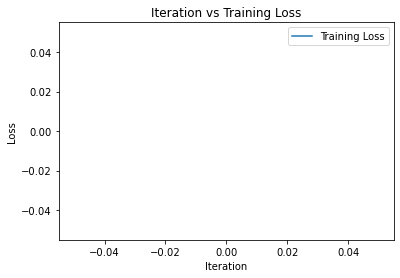

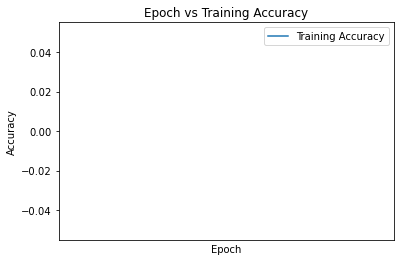

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

## **Testing**

In [ ]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(X_train, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

  0%|          | 0/11518 [00:00<?, ?it/s]


IndexError: too many indices for tensor of dimension 2